In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import utils_prep
import RNNEncoder
import RNNDecoder
import Attention

# Загрузка и анализ данных (№2, a)

In [3]:
df = pd.read_csv(r'data/babynames_extended.csv')

In [4]:
df

,Name,Gender,Name_RU
0,John,boy,Джон
1,William,boy,Уильям
2,James,boy,Джеймс
3,Charles,boy,Чарльз
4,George,boy,Джордж
...,...,...,...
6777,Laylah,girl,Лейла
6778,Carleigh,girl,Карли
6779,Kenley,girl,Кенли
6780,Sloane,girl,Слоан


In [5]:
df.Gender.value_counts()/df.shape[0]*100

Gender
boy     50.678266
girl    49.321734
Name: count, dtype: float64

# Подготовка данных (№2, b-d)

In [6]:
PAD_token = "."  # Padding
SOS_token = "<"  # Start Of Sequence
EOS_token = ">"  # End Of Sequence

In [7]:
df['Name'] = df['Name'].str.lower().str.strip()
df['Name_RU'] = df['Name_RU'].str.lower().str.strip()

In [8]:
eng_char2idx, eng_idx2char = utils_prep.build_vocab(df['Name'].tolist(), specials = [SOS_token, EOS_token, PAD_token])
rus_char2idx, rus_idx2char = utils_prep.build_vocab(df['Name_RU'].tolist(), specials = [SOS_token, EOS_token, PAD_token])

In [9]:
df[df['Name_RU'].str.contains(" ")]

,Name,Gender,Name_RU
712,ivory,boy,слоновая кость
962,gee,boy,ну и дела
1009,deforest,boy,вырубка леса
1235,josephus,boy,иосиф флавий
3818,arie,girl,орлиное гнездо
4528,nova,girl,новая звезда
5871,sunshine,girl,солнечный свет


In [10]:
X = [utils_prep.encode_name(name, eng_char2idx, SOS_token, EOS_token) for name in df['Name']]
y = [utils_prep.encode_name(name, rus_char2idx, SOS_token, EOS_token) for name in df['Name_RU']]

In [11]:
X_padded, X_max_length = utils_prep.pad_sequences(X, eng_char2idx[PAD_token])
y_padded, y_max_length = utils_prep.pad_sequences(y, rus_char2idx[PAD_token])

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y_padded, test_size=0.2, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [13]:
X_train_t = torch.tensor(X_train, dtype=torch.long)
X_valid_t = torch.tensor(X_valid, dtype=torch.long) 
X_test_t  = torch.tensor(X_test, dtype=torch.long)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_valid_t = torch.tensor(y_valid, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

In [14]:
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [15]:
for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
    # Проверяем каждый target token в batch_y
    pad_idx = rus_char2idx['.']
    
    print(batch_y[:, 13]) # 11-й шаг (0-based)
    print(batch_y[0])
    
    break

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor([ 0,  4, 20, 20,  4,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2])


In [16]:
y_max_length

21

# RNN Encoder. №3

In [189]:
model = RNNEncoder.RNNEncoder(len(eng_char2idx), embed_size=32, hidden_size=32)

In [21]:
num_epochs = 10

In [191]:
%%time
train_losses, valid_losses = RNNEncoder.train_rnn_encoder(
    model, train_loader, valid_loader, pad_idx = eng_char2idx[PAD_token], epochs=num_epochs
)

Epoch 1: 100%|██████████| 85/85 [00:00<00:00, 135.57it/s]


Epoch 1: Train=2.9546, Valid=2.6498


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 145.38it/s]


Epoch 2: Train=2.5361, Valid=2.4541


Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 159.65it/s]


Epoch 3: Train=2.3915, Valid=2.3628


Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 164.46it/s]


Epoch 4: Train=2.3169, Valid=2.3065


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 162.99it/s]


Epoch 5: Train=2.2691, Valid=2.2715


Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 146.14it/s]


Epoch 6: Train=2.2376, Valid=2.2451


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 172.92it/s]


Epoch 7: Train=2.2131, Valid=2.2266


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 164.47it/s]


Epoch 8: Train=2.1933, Valid=2.2112


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 173.46it/s]


Epoch 9: Train=2.1775, Valid=2.1995


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 168.14it/s]


Epoch 10: Train=2.1640, Valid=2.1889
CPU times: user 5.43 s, sys: 253 ms, total: 5.68 s
Wall time: 5.75 s


In [201]:
for name, param in model.named_parameters():
    if 'weight' in name and 'gru' in name:
        print(f"{name}: norm={param.norm().item():.4f}, mean={param.mean().item():.4f}")

gru.weight_ih_l0: norm=9.0465, mean=0.0057
gru.weight_hh_l0: norm=10.4952, mean=0.0014


In [193]:
device = next(model.parameters()).device
        
        
test_input = torch.tensor([[9, 7, 17, 8, 8]], device=device)  # "geoff"
hidden = model.get_encoder_state(test_input)
print(f"Hidden norm: {hidden.norm().item():.4f}")
print(f"Hidden min/max: {hidden.min().item():.4f}/{hidden.max().item():.4f}")

# Проверь чувствительность
test_input2 = torch.tensor([[9, 7, 17, 8, 9]], device=device)  # "geofg"
hidden2 = model.get_encoder_state(test_input2)

cos_sim = torch.cosine_similarity(hidden.flatten(), hidden2.flatten(), dim=0)
print(f"Cosine similarity: {cos_sim.item():.4f}")

Hidden norm: 4.3208
Hidden min/max: -0.9696/0.9930
Cosine similarity: 0.8364


In [194]:
generated_names = RNNEncoder.generate_names(model, sos_idx = eng_char2idx[SOS_token], eos_idx = eng_char2idx[EOS_token], pad_idx = eng_char2idx[PAD_token], eng_idx2char = eng_idx2char, max_len = X_max_length)
print("\nGenerated English names:")
for i, name in enumerate(generated_names, 1):
    print(f"{i:2d}. {name}")


Generated English names:
 1. caldia
 2. vilsie
 3. tlielle
 4. arlic
 5. janda
 6. arlin
 7. jori
 8. harylla
 9. berada
10. lation


# RNN Machine Translation. Decoder. №4

In [195]:
encoder = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=32, hidden_size=32)

✅ Encoder загружен


In [209]:
rus_vocab_size = len(rus_char2idx)
decoder, train_losses, valid_losses = RNNDecoder.train_decoder(
    encoder, train_loader, valid_loader, len(rus_char2idx), eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx, 
                  X_valid_t, y_valid_t, y_max_length, num_epochs, embed_size=64, hidden_size=32
)

Training Decoder (Encoder frozen)...


Epoch 1: 100%|██████████| 85/85 [00:03<00:00, 23.00it/s]


Epoch 1: Train=2.7974, Valid=2.4032


Epoch 2: 100%|██████████| 85/85 [00:03<00:00, 24.81it/s]


Epoch 2: Train=2.2830, Valid=2.2238


Epoch 3: 100%|██████████| 85/85 [00:03<00:00, 25.22it/s]


Epoch 3: Train=2.1320, Valid=2.1126


Epoch 4: 100%|██████████| 85/85 [00:03<00:00, 24.48it/s]


Epoch 4: Train=2.0432, Valid=2.0444


Epoch 5: 100%|██████████| 85/85 [00:03<00:00, 25.13it/s]


Epoch 5: Train=1.9891, Valid=1.9979


Epoch 6: 100%|██████████| 85/85 [00:03<00:00, 24.62it/s]


Epoch 6: Train=1.9416, Valid=1.9663


Epoch 7: 100%|██████████| 85/85 [00:03<00:00, 23.45it/s]


Epoch 7: Train=1.8987, Valid=1.9436


Epoch 8: 100%|██████████| 85/85 [00:03<00:00, 22.85it/s]


Epoch 8: Train=1.8729, Valid=1.9265


Epoch 9: 100%|██████████| 85/85 [00:03<00:00, 23.19it/s]


Epoch 9: Train=1.8480, Valid=1.9079


Epoch 10: 100%|██████████| 85/85 [00:03<00:00, 21.68it/s]


Epoch 10: Train=1.8235, Valid=1.8941


In [211]:
RNNDecoder.check_translation(X_test_t, eng_char2idx, eng_idx2char, decoder, encoder, rus_char2idx, rus_idx2char, len(rus_char2idx), 10)

  geoff      → на
  bush       → кан
  landyn     → джани
  antone     → кан
  naoma      → кин
  freddy     → ариль
  clarissa   → кари
  graves     → джери
  harriet    → кани
  tomika     → кари


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

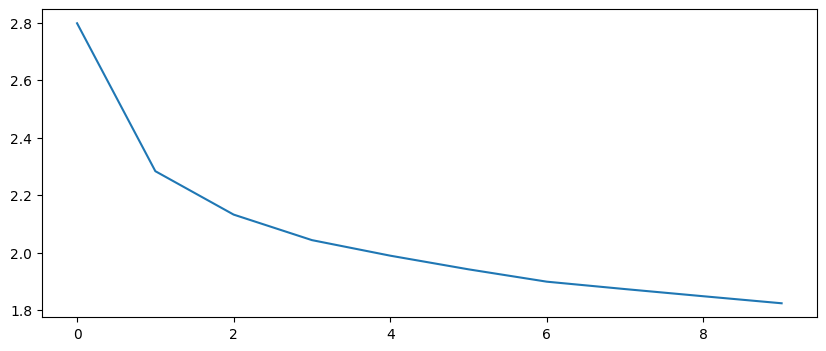

In [ ]:
# 3. График loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Decoder Training')
plt.show()

# 4. Perplexity на test
ppl = RNNDecoder.compute_perplexity(decoder, encoder, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")
    
    

In [216]:
ppl = RNNDecoder.compute_perplexity(decoder, encoder, test_loader, rus_char2idx)
print(f"\n✅ Test Perplexity: {ppl:.2f}")


✅ Test Perplexity: 28.69


# Attention Machine Translation. №5

In [17]:
encoder = RNNEncoder.load_encoder(len(eng_char2idx), embed_size=32, hidden_size=32)

✅ Encoder загружен


In [22]:
attention_decoder, train_losses, valid_losses = Attention.train_attention_decoder(
        encoder, train_loader, valid_loader, len(rus_char2idx), 
        eng_idx2char, rus_idx2char, eng_char2idx, rus_char2idx,
        X_valid_t, y_valid_t, epochs=num_epochs
    )

Training Attention Decoder...


Epoch 1: 100%|██████████| 85/85 [00:00<00:00, 112.84it/s]


Epoch 1: Train=3.3608, Valid=3.0960


Epoch 2: 100%|██████████| 85/85 [00:00<00:00, 138.32it/s]


Epoch 2: Train=2.8948, Valid=2.8001


Epoch 3: 100%|██████████| 85/85 [00:00<00:00, 121.92it/s]


Epoch 3: Train=2.7010, Valid=2.6753


Epoch 4: 100%|██████████| 85/85 [00:00<00:00, 131.71it/s]


Epoch 4: Train=2.5845, Valid=2.5784


Epoch 5: 100%|██████████| 85/85 [00:00<00:00, 135.98it/s]


Epoch 5: Train=2.4926, Valid=2.5013


Epoch 6: 100%|██████████| 85/85 [00:00<00:00, 127.62it/s]


Epoch 6: Train=2.4166, Valid=2.4320


Epoch 7: 100%|██████████| 85/85 [00:00<00:00, 114.27it/s]


Epoch 7: Train=2.3516, Valid=2.3759


Epoch 8: 100%|██████████| 85/85 [00:00<00:00, 130.84it/s]


Epoch 8: Train=2.2997, Valid=2.3298


Epoch 9: 100%|██████████| 85/85 [00:00<00:00, 128.46it/s]


Epoch 9: Train=2.2585, Valid=2.2936


Epoch 10: 100%|██████████| 85/85 [00:00<00:00, 131.35it/s]

Epoch 10: Train=2.2245, Valid=2.2624


In [24]:
attention_decoder

AttentionDecoder(
  (embedding): Embedding(36, 64)
  (gru): GRU(96, 32, batch_first=True)
  (attention): Linear(in_features=64, out_features=32, bias=True)
  (attention_combine): Linear(in_features=64, out_features=32, bias=True)
  (fc_out): Linear(in_features=32, out_features=36, bias=True)
)

In [23]:
RNNDecoder.check_translation(X_test_t, eng_char2idx, eng_idx2char, attention_decoder, encoder, rus_char2idx, rus_idx2char, len(rus_char2idx), 10)

  geoff      → марлин
  bush       → кардерин
  landyn     → кари
  antone     → джерин
  naoma      → лелина
  freddy     → лини
  clarissa   → лина
  graves     → керин
  harriet    → джери
  tomika     → лина
